In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
import os
os.getcwd()

'C:\\Users\\纪明辰'

In [3]:
import os
#path = 'data' + os.sep + 'LogiReg_data.txt'
#print(path)
Data = pd.read_csv("LogiReg_data.txt",header=None,names=['Exam 1','Exam 2','Admitted'])
Data.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [4]:
Data.shape

(100, 3)

In [5]:
#画出数据图像
positive = Data[Data['Admitted'] == 1]    #指定子集
negative = Data[Data['Admitted'] == 0]

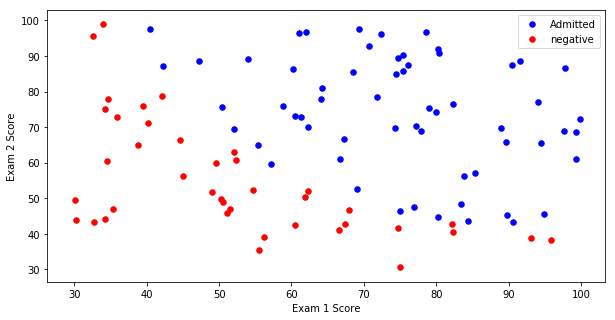

In [6]:
fig,ax = plt.subplots(figsize=(10,5))
ax.scatter(positive['Exam 1'],positive['Exam 2'],s=30,c='b',marker='o',label='Admitted')
ax.scatter(negative['Exam 1'],negative['Exam 2'],s=30,c='r',marker='o',label='negative')
ax.legend()
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')
plt.show()

# the Logistic Regression

### 目标：建立分类器，求出参数$\theta$
### 要完成的模块：
###                          sigmoid:映射到概率的函数
###                          model:返回预测结果值
###                          cost:根据参数计算损失
###                          gradient:计算每个参数的梯度方向
###                          descent:进行参数更新
###                          accuracy:计算精度

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

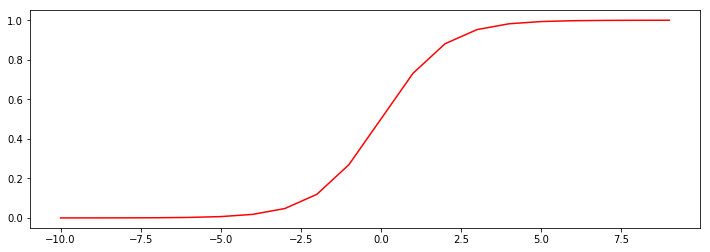

In [8]:
nums = np.arange(-10,10,step = 1)
fig, ax = plt.subplots(figsize = (12,4))
ax.plot(nums, sigmoid(nums),'r')

In [9]:
def model(X,theta):
    return sigmoid(np.dot(X, theta.T))

In [10]:
Data.insert(0,'Ones',1)    #插入一列1，列名Ones

orig_data = Data.as_matrix()
cols = orig_data.shape[1]    #返回矩阵列数
X = orig_data[:,0:cols-1]
y = orig_data[:,cols-1:cols]

theta = np.zeros([1,3])      #参数初始化

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
X[:5]

array([[ 1.        , 34.62365962, 78.02469282],
       [ 1.        , 30.28671077, 43.89499752],
       [ 1.        , 35.84740877, 72.90219803],
       [ 1.        , 60.18259939, 86.3085521 ],
       [ 1.        , 79.03273605, 75.34437644]])

In [12]:
y[:5]

array([[0.],
       [0.],
       [0.],
       [1.],
       [1.]])

In [13]:
theta

array([[0., 0., 0.]])

In [14]:
X.shape,y.shape,theta.shape

((100, 3), (100, 1), (1, 3))

### 定义损失函数 

In [15]:
def cost(X,y,theta):
    left = np.multiply(-y,np.log(model(X,theta)))
    right = np.multiply(1-y,np.log(1-model(X,theta)))
    return np.sum(left-right)/len(X)

In [16]:
cost(X, y, theta)

0.6931471805599453

### 计算梯度 

In [17]:
def gradient(X,y,theta):
    grad = np.zeros(theta.shape)
    error = (model(X,theta)-y).ravel()
    for j in range(len(theta.ravel())):
        term = np.multiply(error,X[:,j])
        grad[0,j]=np.sum(term)/len(X)
    return grad

### 梯度下降 

In [18]:
def stopCriterion(type,value,threshold):
    #三种不同的停止策略：迭代次数达到阈值、目标函数差异小于阈值、梯度变化小于阈值
    if type == 'Stop_iter':
        return value > threshold
    elif type == 'Stop_cost':
        return abs(value[-1]-value[-2]) < threshold
    elif type == 'Stop_grad':
        return np.linalg.norm(value) < threshold    #求范数（默认二范数）


In [19]:
import numpy.random
#洗牌
def shuffleData(data):
    np.random.shuffle(data)
    cols=data.shape[1]
    X = data[:,0:cols-1]
    y = data[:,cols-1:]
    return X,y

In [20]:
import time
#梯度下降求解
def descent(data, theta, batchSize, stopType, thresh, alpha):
    init_time = time.time()
    i = 0                          #迭代次数
    k = 0                          #batch
    X,y = shuffleData(data)        #打乱顺序提升模型泛化能力
    grad = np.zeros(theta.shape)   #计算的梯度
    costs = [cost(X,y,theta)]      #损失值
 
    while True:
        grad = gradient(X[k:k+batchSize],y[k:k+batchSize],theta)
        k += batchSize
        if k >= n:
            k = 0 
            X,y = shuffleData(data)     #重新洗牌
        theta = theta - alpha * grad    #参数更新
        costs.append(cost(X,y,theta))
        i += 1
 
        if stopType == 'Stop_iter':
            value=i
        elif stopType == 'Stop_cost':
            value=costs
        elif stopType == 'Stop_grad':
            value = grad
        else:
            print('stopType 参数设置错误，请重试')
            break
        if stopCriterion(stopType,value,thresh):
            break
 
    return theta, i-1, costs, grad, time.time()-init_time

In [21]:
#结果展示
def runExpe(data, theta, batchSize, stopType, thresh, alpha):
    #执行一次梯度下降
    theta, i, costs, grad, dur = descent(data, theta, batchSize, stopType, thresh, alpha)
    #图标题
    name = "Original"  if (data[:,1]>2).sum() > 1 else "Scaled"
    name += "data - learning rate: {} -".format(alpha)
    #选择参数初始化的方式
    if batchSize == n:
        strDescType = "Gradient"      #梯度下降法
    elif batchSize == 1:
        strDescType = "Stochastic"    #随机梯度下降
    else:
        strDescType = "Mini-batch({})".format(batchSize)    #Mini-batch
    name += strDescType + "descent - Stop:"
    #选择停止策略
    if stopType == 'Stop_iter':
        strStop = "{} iterations".format(thresh)
    elif stopType == 'Stop_cost':
        strStop = "costs change < {}".format(thresh)
    else:
        strStop = "gradient norm < {}".format(thresh)
    name += strStop
    
    print("***{}\nTheta:{} - Iter:{} - Last cost:{:03.2f} - Duration:{:03.2f}s".format(name,theta,i,costs[-1],dur))
    
    fig, ax = plt.subplots(figsize = (12,4))
    ax.plot(np.arange(len(costs)),costs,'r')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.set_title(name.upper() + ' - Error vs. Iteration')
    return theta      

# 对比停止策略

### 根据迭代次数停止

***Originaldata - learning rate: 1e-06 -Gradientdescent - Stop:5000 iterations
Theta:[[-0.00027127  0.00705232  0.00376711]] - Iter:5000 - Last cost:0.63 - Duration:0.73s


array([[-0.00027127,  0.00705232,  0.00376711]])

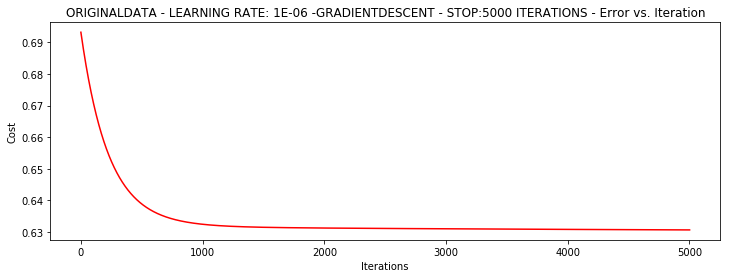

In [22]:
#送入所有样本
n = 100
runExpe(orig_data, theta, n, 'Stop_iter', thresh=5000, alpha=0.000001)

### 根据损失阈值停止 

***Originaldata - learning rate: 0.001 -Gradientdescent - Stop:costs change < 1e-06
Theta:[[-5.13364014  0.04771429  0.04072397]] - Iter:109901 - Last cost:0.38 - Duration:16.90s


array([[-5.13364014,  0.04771429,  0.04072397]])

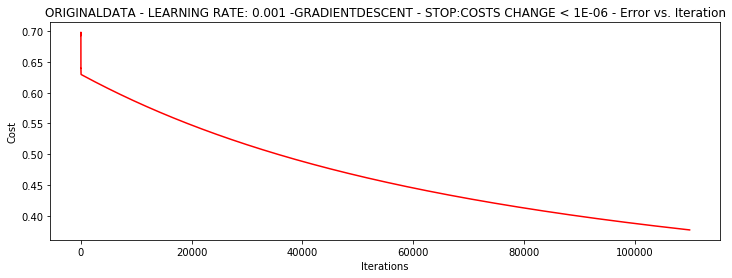

In [39]:
runExpe(orig_data, theta, n, 'Stop_cost', thresh=0.000001, alpha=0.001)

### 根据梯度变化停止 

***Originaldata - learning rate: 0.001 -Gradientdescent - Stop:gradient norm < 0.05
Theta:[[-2.37033409  0.02721692  0.01899456]] - Iter:40045 - Last cost:0.49 - Duration:6.28s


array([[-2.37033409,  0.02721692,  0.01899456]])

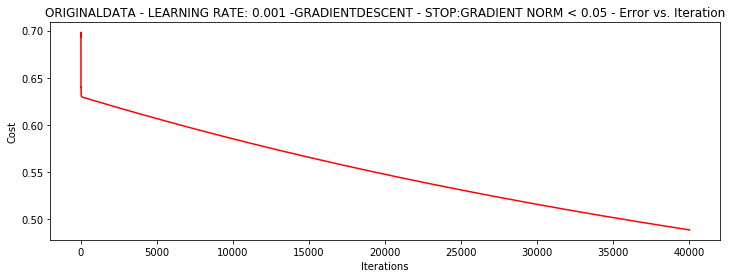

In [40]:
runExpe(orig_data, theta, n, 'Stop_grad', thresh=0.05, alpha=0.001)

# 对比不同的梯度下降方法

### Stochastic descent 

***Originaldata - learning rate: 0.001 -Stochasticdescent - Stop:5000 iterations
Theta:[[-0.38257563  0.00889669  0.04001151]] - Iter:5000 - Last cost:0.98 - Duration:0.23s


array([[-0.38257563,  0.00889669,  0.04001151]])

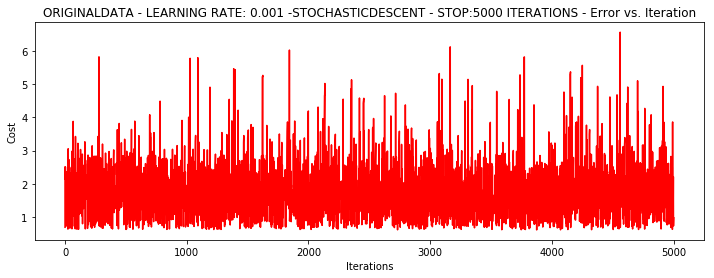

In [41]:
#模型不收敛
runExpe(orig_data, theta, 1, 'Stop_iter', thresh=5000, alpha=0.001 )

***Originaldata - learning rate: 2e-06 -Stochasticdescent - Stop:15000 iterations
Theta:[[-0.00202065  0.01006478  0.00100494]] - Iter:15000 - Last cost:0.63 - Duration:0.73s


array([[-0.00202065,  0.01006478,  0.00100494]])

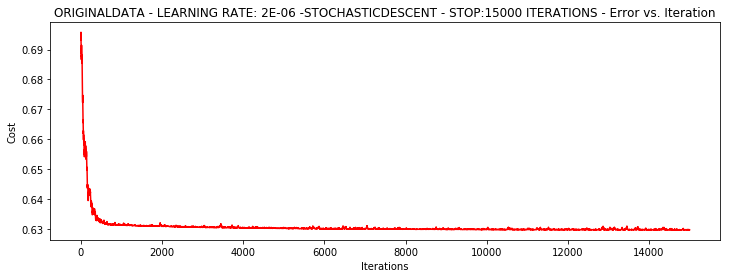

In [42]:
#学习率调小，迭代次数增多
#随机梯度下降的特性：损失有抖动
runExpe(orig_data, theta, 1, 'Stop_iter', thresh=15000, alpha=0.000002 )

### Mini-batch descent 

***Originaldata - learning rate: 0.001 -Mini-batch(16)descent - Stop:15000 iterations
Theta:[[-1.03600375  0.0127313  -0.01600435]] - Iter:15000 - Last cost:1.02 - Duration:0.88s


array([[-1.03600375,  0.0127313 , -0.01600435]])

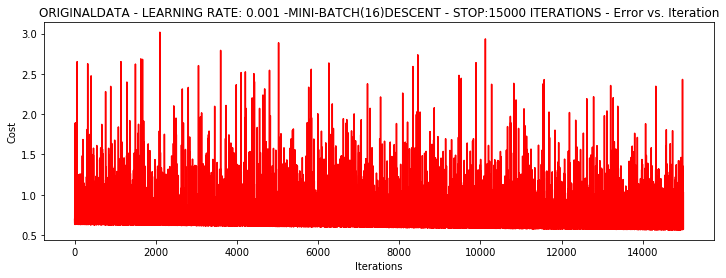

In [43]:
runExpe(orig_data, theta, 16, 'Stop_iter', thresh=15000, alpha=0.001 )

### 浮动太大，进行数据标准化，将数据按列（属性）进行标准化（减去均值，除以方差），得到结果数据的每个属性都聚集在0附近，方差值为1

***Scaleddata - learning rate: 0.001 -Gradientdescent - Stop:5000 iterations
Theta:[[0.3080807  0.86494967 0.77367651]] - Iter:5000 - Last cost:0.38 - Duration:0.75s


array([[0.3080807 , 0.86494967, 0.77367651]])

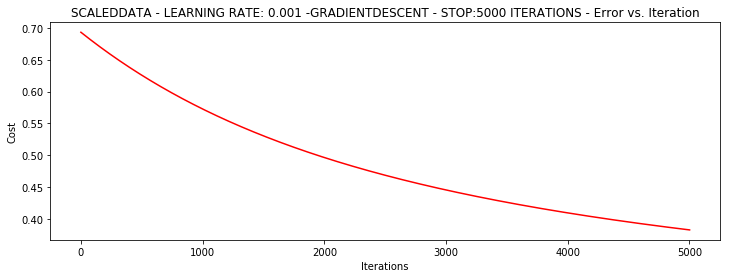

In [23]:
from sklearn import preprocessing as pp

scaled_data = orig_data.copy()
scaled_data[:,1:3] = pp.scale(orig_data[:,1:3])

runExpe(scaled_data, theta, n, 'Stop_iter', thresh=5000, alpha=0.001)

### 原数据收敛到0.61左右，标准化后达到0.38

***Scaleddata - learning rate: 0.001 -Stochasticdescent - Stop:gradient norm < 0.0004
Theta:[[1.14723121 2.79266437 2.56609182]] - Iter:72550 - Last cost:0.22 - Duration:3.72s


array([[1.14723121, 2.79266437, 2.56609182]])

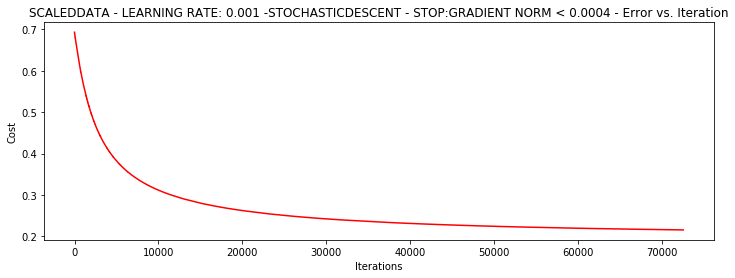

In [25]:
runExpe(scaled_data, theta, 1, 'Stop_grad', thresh=0.002/5, alpha=0.001 )

***Scaleddata - learning rate: 0.001 -Mini-batch(16)descent - Stop:gradient norm < 0.004
Theta:[[1.07303137 2.6365463  2.41490013]] - Iter:59828 - Last cost:0.22 - Duration:4.26s


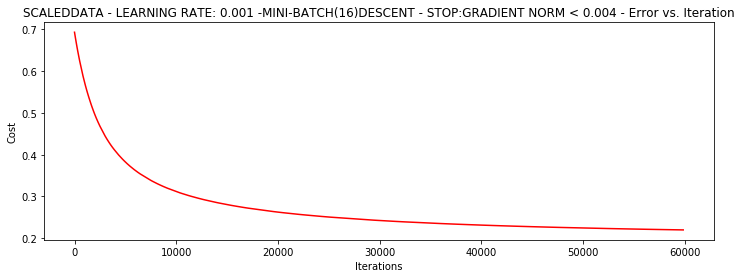

In [36]:
theta = runExpe(scaled_data, theta, 16, 'Stop_grad', thresh=0.002*2, alpha=0.001 )

# 精度

In [27]:
#设定阈值0.5
def predict(X, theta):
    return [1 if x >= 0.5 else 0 for x in model(X, theta)]

In [37]:
scaled_X = scaled_data[:,:3]
y = scaled_data[:, 3]
predictions = predict(scaled_X, theta)
correct = [1 if ((a == 1 and b == 1) or (a ==0 and b ==0)) else 0 for (a,b) in zip(predictions, y)]
accuracy = (sum(map(int,correct)) % len(correct))
print('accuracy = {0}%'.format(accuracy))

accuracy = 89%
